In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
import pickle
file_x = open('./ofm_dataset_x.pkl', 'rb')
file_y = open('./ofm_dataset_y.pkl', 'rb')
X = pickle.load(file_x, encoding='bytes')

# print size of dataset
print('Dataset-Size: {}'.format(X.shape[0]))

# find max and min element in X
minMat = np.min(X)
maxMat = np.max(X)
print("Min Element: {}\nMax Element: {}".format(minMat, maxMat))

Y = pickle.load(file_y, encoding='bytes')
# X = np.stack((X,)*3, axis=-1)

Dataset-Size: 1005
Min Element: 0.0
Max Element: 2.5780038377488013


In [17]:
dataset_size = X.shape[0]
train_size = int((dataset_size*90)/100)
X_train = X[:train_size]
Y_train = Y[:train_size]
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
Y_train = Y_train[idx]

### set Y to 0 for testing 
Y_train = Y_train

X_test = X[train_size:]
Y_test = Y[train_size:]

In [18]:
# Hyperparams
BATCH_SIZE = 4
LR = 0.003 # initial Learning Rate

In [19]:
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms

class FingerprintDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.samples[0][index]
        y = self.samples[1][index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, torch.tensor(y)
    
    def __len__(self):
        return self.samples[0].shape[0]

In [20]:
transform = transforms.Compose([
     transforms.ToTensor()])

train_dataset = FingerprintDataset((X_train, Y_train), transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = FingerprintDataset((X_test, Y_test), transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

torch.Size([4, 1, 32, 32])


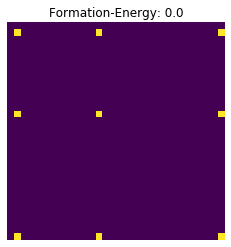

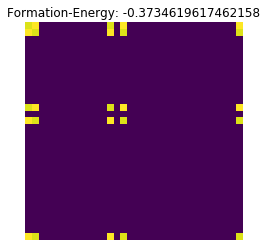

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img, label, predicted=False):
    npimg = np.uint8((img.numpy()*255.0)/maxMat)
    npimg = np.transpose(npimg, (1, 2, 0))
    img = np.reshape(npimg, (npimg.shape[0], npimg.shape[1]))
    if predicted==False:    
        plt.title("Formation-Energy: {}".format(label))
    else:
        plt.title("Formation-Energy\n   Ground-truth: {}\n   Predicted: {}".format(label, predicted))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show first 2 images from the batch
for i in range(2):
    imshow(images[i], labels[i])

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, input_size=(1, 32, 32)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, (5, 5)), # padding = (F-1)/2 (to keep the size constant) 
            nn.ReLU(),
            nn.Conv2d(32, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
        )
        
        self.flat_fts = self.get_flat_fts(input_size, self.features)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_fts, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        fts = self.features(x)
        flat_fts = fts.view(-1, self.flat_fts)
        out = self.classifier(flat_fts)
        return out

In [23]:
net = Net()
net = net.float()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=7744, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [12]:
import torch.optim as optim

# criterion = nn.L1Loss()
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# optimizer = optim.Adam(net.parameters(), lr=LR)
optimizer = optim.RMSprop(net.parameters(), lr=LR)

In [30]:
def adjust_learning_rate(optimizer, epoch, k):
    """Sets the learning rate to the initial LR decayed by 10 every k epochs"""
    assert type(k) is int
    lr = LR * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [36]:
def train(trainloader, numEpochs, k):
    
    for epoch in range(numEpochs):  # loop over the dataset multiple times
        running_loss = 0.0
        if epoch != 0 and epoch%k==0: adjust_learning_rate(optimizer, epoch, k)
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].float().to(device), (torch.squeeze(data[1])).float().to(device)
            labels = torch.squeeze(labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # print(inputs.shape)
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')

In [37]:
"""Sets the learning rate to the initial LR decayed by 10 every k epochs"""
k = 1
train(train_loader, 50, 10)

Finished Training


In [38]:
PATH = './propertyPredictionUsingOFM_net.pth'
# torch.save(net.state_dict(), PATH)

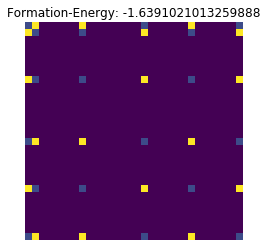

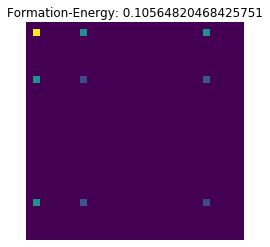

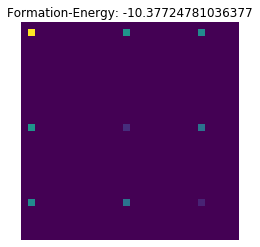

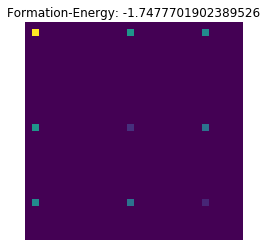

In [40]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
for i in range(BATCH_SIZE):
    imshow(images[i], labels[i])

In [47]:
net = Net()
net = net.float()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [48]:
outputs = net(images.float())